## Setup

In [ ]:
!pip install --quiet pytorch-forecasting[mqf2]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [80]:
from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Processing and Exploration

The labels to predict are : 

* p(mbar)
* T (degC)
* rh (%)
* wv (m/s)

In [ ]:
def custom_date_parser(date_string):
    return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')

In [ ]:
data = pd.read_csv(os.path.join(path, "weather_train.csv"), parse_dates = ['Date Time'], date_parser=custom_date_parser)
data.head()

<ipython-input-32-806ade3554b6>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [ ]:
data.sort_values(by='Date Time', ascending=True, inplace=True)

Let's rename the labels so that they are more convenient to use.

In [ ]:
data = data.rename(columns={'p (mbar)': 'p', 'T (degC)': 'T', 'rh (%)': 'rh', 'wv (m/s)': 'wv', 'Date Time': 'date'})

With some prior exploration, we saw that not all time stamps were from a round hour, this could have caused non consecutive hours, eventhough the time stamps belonged to the same hour. In order to cope with that, we set the minute to always be "00".

In [ ]:
data['date'] = data['date'].apply(lambda x: x.replace(minute=0))

Let's check if there are non consecutive dates in the dataset

In [ ]:
# create an empty list to store the indices of non-consecutive rows
non_consecutive_rows = []

# iterate through the rows of the dataframe
for i in range(1, len(data)):
    # get the current and previous timestamps
    curr_timestamp = data['date'][i]
    prev_timestamp = data['date'][i-1]
    
    # check if the difference between the timestamps is greater than one hour
    if (curr_timestamp - prev_timestamp) > pd.Timedelta(hours=1):
        # if so, append the index of the current row to the list of non-consecutive rows
        non_consecutive_rows.append(i)

# display the list of non-consecutive rows
print(f"Number of non consecutive rows {len(non_consecutive_rows)}")
print(f"Percentage of non consecutive rows : {len(non_consecutive_rows) / len(data['date']) * 100:.1f}%")

Number of non consecutive rows 1
Percentage of non consecutive rows : 0.0%


Virtually, we only have consecutive dates.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56072 entries, 0 to 56071
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             56072 non-null  datetime64[ns]
 1   p                56072 non-null  float64       
 2   T                56072 non-null  float64       
 3   Tpot (K)         56072 non-null  float64       
 4   Tdew (degC)      56072 non-null  float64       
 5   rh               56072 non-null  float64       
 6   VPmax (mbar)     56072 non-null  float64       
 7   VPact (mbar)     56072 non-null  float64       
 8   VPdef (mbar)     56072 non-null  float64       
 9   sh (g/kg)        56072 non-null  float64       
 10  H2OC (mmol/mol)  56072 non-null  float64       
 11  rho (g/m**3)     56072 non-null  float64       
 12  wv               56072 non-null  float64       
 13  max. wv (m/s)    56072 non-null  float64       
 14  wd (deg)         56072 non-null  float

Now, let's explore some basic label / date relationships.

<Axes: xlabel='date'>

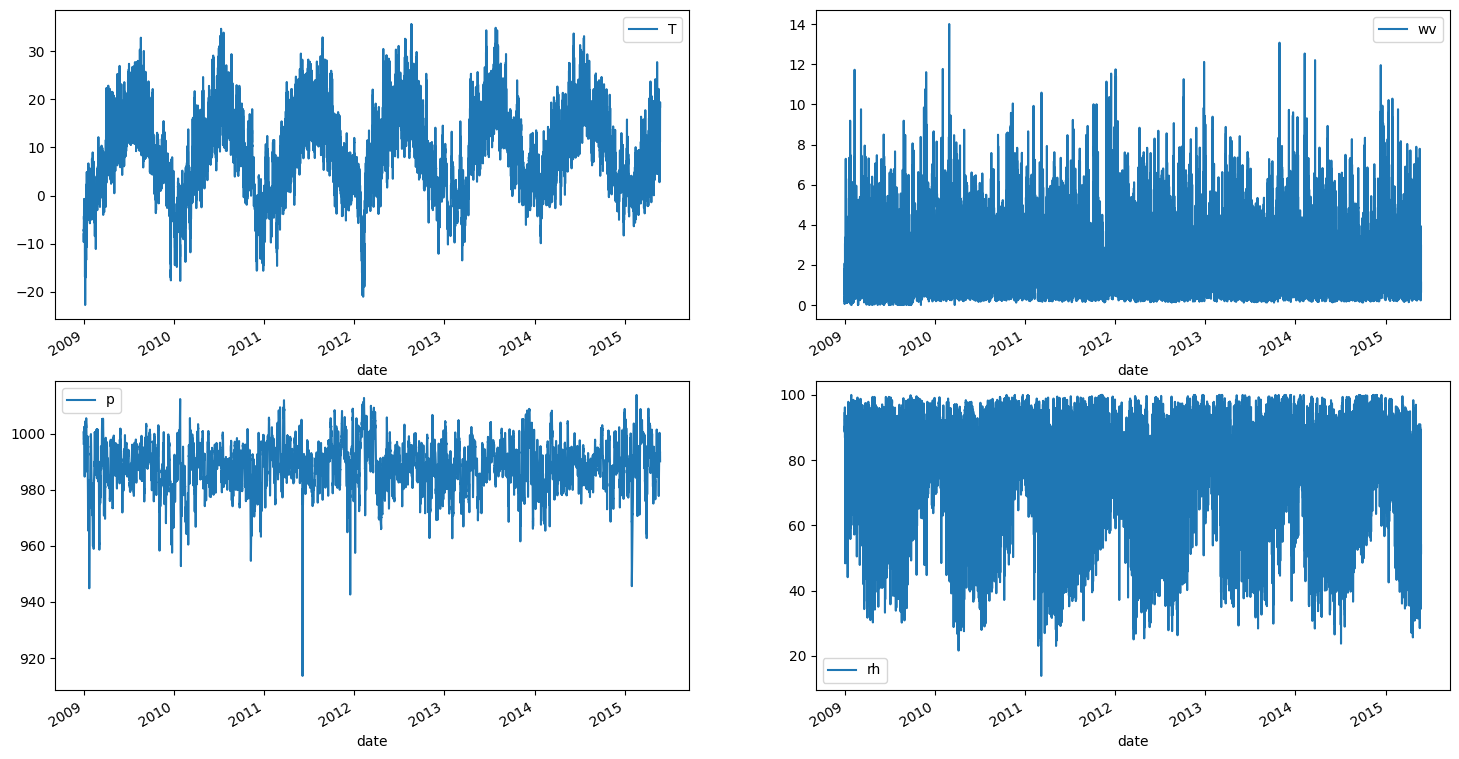

In [ ]:
# create a subplot with 4 rows and 1 column
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

# plot the graphs for each label
data.plot(ax=ax[0][0], x='date', y='T')
data.plot(ax=ax[1][0], x='date', y='p')
data.plot(ax=ax[1][1], x='date', y='rh')
data.plot(ax=ax[0][1], x='date', y='wv')

In [ ]:
'''remove time stamp but keep all features'''
data = data.drop('date', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56072 entries, 0 to 56071
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p                56072 non-null  float64
 1   T                56072 non-null  float64
 2   Tpot (K)         56072 non-null  float64
 3   Tdew (degC)      56072 non-null  float64
 4   rh               56072 non-null  float64
 5   VPmax (mbar)     56072 non-null  float64
 6   VPact (mbar)     56072 non-null  float64
 7   VPdef (mbar)     56072 non-null  float64
 8   sh (g/kg)        56072 non-null  float64
 9   H2OC (mmol/mol)  56072 non-null  float64
 10  rho (g/m**3)     56072 non-null  float64
 11  wv               56072 non-null  float64
 12  max. wv (m/s)    56072 non-null  float64
 13  wd (deg)         56072 non-null  float64
dtypes: float64(14)
memory usage: 8.4 MB


## Model 1: Fully Connected Baseline (k=4; 3 hidden layers) - COMPLETE

In [107]:
INPUT_SIZE = 4*14
OUTPUT_SIZE = 4

'''reorganize dataset into samples (build "X" and "y" below)'''
# Total number of time steps: 56072; each sample spans 5 time steps (4 input + 1 output)
data = np.array(data)
X = np.zeros((56072-4, INPUT_SIZE))
y = np.zeros((56072-4, OUTPUT_SIZE))

for i in range(56072-4):
  X[i, :] = data[i:i+4, :].reshape(1, INPUT_SIZE)
  y[i, :] = data[i+4, [0, 1, 4, 11]] # four output features

In [108]:
# data loader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

X = torch.Tensor(X)
y = torch.Tensor(y)

class WeatherDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    return self.X[idx, :], self.y[idx, :]

In [109]:
'''
build fully connected model:
1) k = 4
2) three hidden layers
3) 4 nodes in each hidden layer
4) fully connected NN
'''

class FullyConnectModel(nn.Module):
  def __init__(self):
    super(FullyConnectModel, self).__init__()
    self.layer1 = nn.Linear(INPUT_SIZE, 4)
    self.layer2 = nn.Linear(4, 4)
    self.layer3 = nn.Linear(4, 4)
    self.layerout = nn.Linear(4, OUTPUT_SIZE)

  def forward(self, x):
    x = torch.sigmoid(self.layer1(x))
    x = torch.sigmoid(self.layer2(x))
    x = torch.sigmoid(self.layer3(x))
    return self.layerout(x)

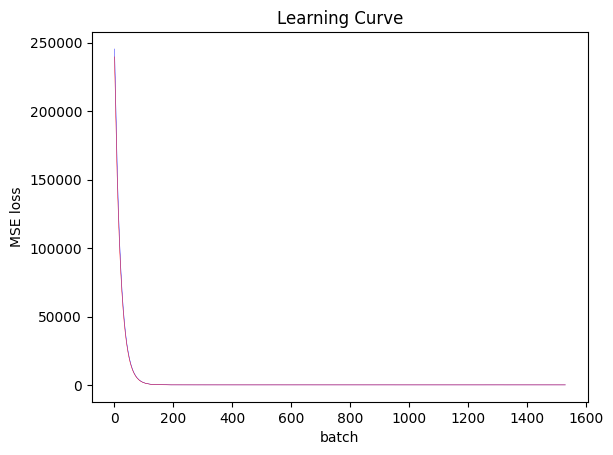

In [110]:
EPOCHES = 30
BATCH_SIZE = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# from torch.utils.data.dataloader import T
dataset = WeatherDataset(X, y)

# train test split
num_test = len(dataset) // 10  # 10% samples for validation
num_train = len(dataset) - num_test
train, val = random_split(dataset, [num_train, num_test])

# load data
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val, batch_size=num_test, shuffle=True)

# model trainning
fc_model = FullyConnectModel()
fc_model.to(device)
criterion = F.mse_loss
optimizer = optim.SGD(fc_model.parameters(), lr=1e-2)

train_loss = []
val_loss = []

for epoch in range(EPOCHES):

  for inputs, labels in train_dataloader:
    inputs = torch.reshape(inputs, (-1, INPUT_SIZE)).to(device)
    labels = labels.to(device)

    # trainning 
    fc_model.train()
    optimizer.zero_grad()
    outputs = fc_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    # validation
    fc_model.eval()
    with torch.no_grad():
      inputs, labels = next(iter(val_dataloader))
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = fc_model(inputs)
      loss = criterion(outputs, labels)
      val_loss.append(loss.item())

# plot learning curve
plt.figure()
plt.title("Learning Curve")
plt.plot(train_loss, linewidth=0.3, c="b")
plt.plot(val_loss, linewidth=0.3, c="r")
plt.xlabel("batch")
plt.ylabel("MSE loss")
plt.show()

In [111]:
print("minimum MSE training loss (fully connected): " + str(min(train_loss)) + "\n")
print("minimum MSE test loss (fully connected): " + str(min(val_loss)) + "\n")

minimum MSE training loss (fully connected): 93.138916015625

minimum MSE test loss (fully connected): 103.2247314453125



## Model 2: LSTM Baseline Model (k=4; 3 hidden layers) - COMPLETE



In [112]:
INPUT_SIZE = 14  # per time step (LSTM)
OUTPUT_SIZE = 4

import torch.nn as nn
import torch

'''
build fully connected model:
1) k = 4
2) three LSTM layers
3) 4 nodes in each hidden state
4) LSTM with a fully connected output layer
5) input data fed in sequentially
'''

class LSTM_model(nn.Module):
  def __init__(self, n_layers):
    super().__init__()
    self.lstm = nn.LSTM(INPUT_SIZE, 4, num_layers=n_layers, batch_first=True)
    self.linear = nn.Linear(4, 4)

  def forward(self, x):
    y, _ = self.lstm(x)
    y = y[:, -1, :]  # last output, all samples in the batch, all features
    return self.linear(torch.sigmoid(y))


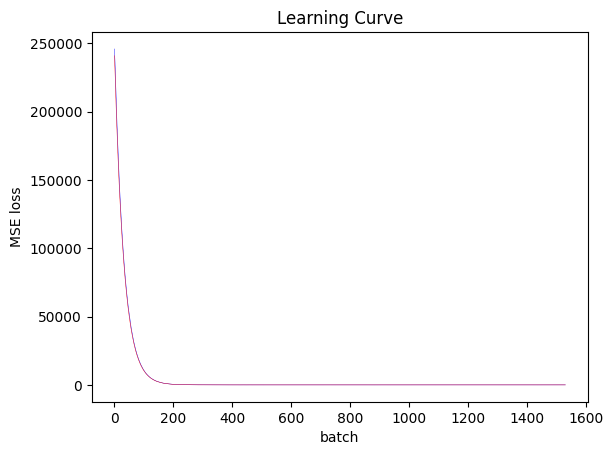

In [113]:
EPOCHES = 30

device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_layers = 3

# construct model 
lstm_model = LSTM_model(n_layers)
optimizer = optim.SGD(lstm_model.parameters(),lr = 1e-2)
lstm_model.to(device)

train_loss = []
val_loss = []

for epoch in range(EPOCHES):

  for inputs, labels in train_dataloader:
    # reshape inputs into correct form for LSTM (same dataloader)
    inputs = torch.reshape(inputs, (-1, 4, INPUT_SIZE))
    inputs = inputs.to(device)
    labels = labels.to(device)

    # trainning 
    fc_model.train()
    optimizer.zero_grad()
    outputs = lstm_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    # validation
    fc_model.eval()
    with torch.no_grad():
      inputs, labels = next(iter(val_dataloader))
      inputs = torch.reshape(inputs, (-1, 4, INPUT_SIZE))
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = lstm_model(inputs)
      loss = criterion(outputs, labels)
      val_loss.append(loss.item())

# plot learning curve
plt.figure()
plt.title("Learning Curve")
plt.plot(train_loss, linewidth=0.3, c="b")
plt.plot(val_loss, linewidth=0.3, c="r")
plt.xlabel("batch")
plt.ylabel("MSE loss")
plt.show()


In [114]:
print("minimum MSE training loss (LSTM): " + str(min(train_loss)) + "\n")
print("minimum MSE test loss (LSTM): " + str(min(val_loss)) + "\n")

minimum MSE training loss (LSTM): 92.58480072021484

minimum MSE test loss (LSTM): 103.22506713867188



## (currently not used...)

In [ ]:
# define the dataset, i.e. add metadata to pandas dataframe for the model to understand it
max_encoder_length = 4
max_prediction_length = 1
training_cutoff = "2015-01-01"  # day for cutoff

In [ ]:
training_ds = TimeSeriesDataSet(
    data[lambda x: x.date <= training_cutoff],
    time_idx= ...,  # column name of time of observation
    target= ...,  # column name of target to predict
    group_ids=[ ... ],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID
    static_categoricals=[ ... ],
    static_reals=[ ... ],
    # covariates known and unknown in the future to inform prediction
    time_varying_known_categoricals=[ ... ],
    time_varying_known_reals=[ ... ],
    time_varying_unknown_categoricals=[ ... ],
    time_varying_unknown_reals=[ ... ],
)

# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training_ds, data, min_prediction_idx=training_ds.index.time.max() + 1, stop_randomization=True)

# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training_ds.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

KeyError: ignored

As the main regularization method, we use early stopping.

In [ ]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

In [ ]:
# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
model = TemporalFusionTransformer.from_dataset(
    # dataset
    training_ds,
    # architecture hyperparameters
    hidden_size=4,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=4,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.03,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {model.size()/1e3:.1f}k")

In [ ]:
# find the optimal learning rate
res = trainer.lr_find(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3)

# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)